# Machine Learning Project: Argument Detection (evidence-claim)
#### Athens University of Economics and Business
#### MSc in Business Analytics
#### Machine Learning & Content Analytics  
#### Team Members: 
         Mikes Manos  (f2821908)           

         Nikolopoulos Filippos  (f2821909)

         Panagiotatos Konstantinos (f2821911)

## Importing libraries

In [1]:
from __future__ import print_function
import numpy as np
import keras
import tensorflow as tf
from pathlib import Path
from pprint import pprint
from tensorflow import keras

from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Flatten, Bidirectional, SpatialDropout1D

import re
import os
from glob import glob
from typing import Tuple, List
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from ipywidgets import interact
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import bert
from itertools import cycle
from typing import List, Tuple
import matplotlib.pyplot as plt

from plot_keras_history import plot_history
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interp

np.random.seed(1228)  # for reproducibility

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Input, Concatenate, Bidirectional, concatenate, GlobalMaxPool1D, Flatten
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from transformers import *

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Running the functions we are going to use in the next steps 

In [2]:
def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

In [3]:
def print_confusion_matrix(y_true,
                           y_pred,
                           class_names: List[str],
                           figsize: Tuple[int, int] = (10, 7),
                           fontsize: int = 14) -> pd.DataFrame:
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heat-map.

    For something more extraordinary check this repo:
    https://github.com/wcipriano/pretty-print-confusion-matrix


    :param class_names:  An ordered list of class names
    :param figsize: A 2-long tuple, the first value determining the horizontal size of the outputted
                    figure, the second determining the vertical size. Defaults to (10,7).
    :param fontsize: Font size for axes labels. Defaults to 14.
    :return: The confusion matrix as a dataset
    """
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    except ValueError:

        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=fontsize)

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return df_cm

In [4]:
def plot_multi_class_roc_auc_curves(nb_classes, y_true, y_pred_score, lw: int = 2):
    """
    ROC, AUC for a categorical classifier
    
    ROC curve extends to problems with three or more classes with what is known as the one-vs-all approach.
    For instance, if we have three classes, we will create three ROC curves,

    For each class, we take it as the positive class and group the rest classes jointly as the negative class.

    Class 1 vs classes 2&3
    Class 2 vs classes 1&3
    Class 3 vs classes 1&2

    :param nb_classes:
    :param y_true:
    :param y_pred_score:
    :param lw:
    :return:
    """

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(nb_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_score[:, i])

        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_score.ravel())

    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(nb_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= nb_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    colors = cycle(['aqua',
                    'darkorange',
                    'cornflowerblue'])

    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1],
             [0, 1],
             'k--',
             lw=lw)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    # plt.show()

    # Zoom in view of the upper left corner.
    plt.figure(2)
    plt.xlim(0, 0.6)
    plt.ylim(0.4, 1)

    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    colors = cycle(['aqua',
                    'darkorange',
                    'cornflowerblue'])

    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1],
             [0, 1],
             'k--', lw=lw)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

## Importing the Dataset

In [5]:
#inserting the dataset
class ArgumentParser:

    @staticmethod
    def get_argument_files():
        return list(Path('argument').glob('**/*.csv'))

    def setup_without_context(self):
        files = self.get_argument_files()
        frames = list()

        for file_path in tqdm(files):
          df = pd.read_csv(file_path)
          try:

            df['label'] = df['label'].str.strip()
            df['label'].replace('_', 'NO LABEL', inplace=True)
            df['label'].replace('Missing', 'NO LABEL', inplace=True)
            df['label'] = df['label'].str.strip().str.upper()
            df['document']=str(file_path).split('\\')[-1]

            frames.append(df)
          except:
            print(df.head())
            print(file_path)
            next()

        data = pd.concat(frames).reset_index(drop=True)
        return {'X': data['sentence'].tolist(),
                'y': data['label'].tolist(),
                'df': data}


if __name__ == "__main__":
    parser = ArgumentParser()

    swc_doc = parser.setup_without_context()
    pprint(swc_doc['X'][:5])
    pprint(swc_doc['y'][:5])

100%|██████████| 889/889 [00:08<00:00, 106.98it/s]


['Multivariate Granger causality between CO2 emissions, energy consumption, '
 'FDI (foreign direct investment) and GDP (gross domestic product): Evidence '
 'from a panel of BRIC (Brazil, Russian Federation, India, and China) '
 'countries',
 'Abstract:',
 'This paper addresses the impact of both economic growth and financial '
 'development on environmental degradation using a panel cointegration '
 'technique for the period between 1980 and 2007, except for Russia '
 '(1992–2007).',
 'In long-run equilibrium, CO2 emissions appear to be energy consumption '
 'elastic and FDI inelastic, and the results seem to support the Environmental '
 'Kuznets Curve (EKC) hypothesis.',
 'The causality results indicate that there exists strong bidirectional '
 'causality between emissions and FDI and unidirectional strong causality '
 'running from output to FDI.']
['NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL', 'EVIDENCE']


In [6]:
# Getting a glimpse at some random rows of the dataset
df=swc_doc['df']
df.sample(10)

,label,sentence,document
10081,NO LABEL,n.).,NRT_G7B2_S1055790315001827.csv
171,NO LABEL,"However, there is little data on its health ef...",ABC_G1B1_10.1016_j.envres.2020.109851.csv
6017,NO LABEL,"Background: In 2014, United Nations member sta...",FOP_G3B3_PMID32046109.csv
7161,NO LABEL,The aim of this study is to investigate the ri...,GOQ_G6B2_PMID_30475818.csv
2325,NO LABEL,"Only sex predicted means for all four traits, ...",DEK_G2B2_27.csv
4078,NO LABEL,"A large-scale sample size of more than 46,000 ...",EIK_G4B3_CorpusID_208358160.csv
9175,NO LABEL,Many policies indirectly address climate varia...,LNR_G5B2_10.7892_BORIS.69298.csv
6489,NO LABEL,Title: Evaluation of a school-based health pro...,GHO_G3B4_CorpusID24228496.csv
10862,NO LABEL,Abstract: This exploratory mixed-methods study...,RST_G7B4_S0959378012001288.csv
2553,NO LABEL,Such a pattern is evident in the tracking of g...,DIJ_G2B2_23.csv


In [7]:
df.dtypes

label       object
sentence    object
document    object
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11064 entries, 0 to 11063
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     11064 non-null  object
 1   sentence  11064 non-null  object
 2   document  11064 non-null  object
dtypes: object(3)
memory usage: 259.4+ KB


## Unique labels 

In [9]:
df.label.unique()

array(['NO LABEL', 'EVIDENCE', 'CLAIM'], dtype=object)

## Checking for missing values

In [10]:
# Checking for missing values
df.isna().sum()

label       0
sentence    0
document    0
dtype: int64

## Number of labels occurences

In [11]:
#getting a sense of the relative numbers of the labels
df.drop(['sentence'],1).groupby(['label']).count()

,document
label,
CLAIM,990
EVIDENCE,1486
NO LABEL,8588


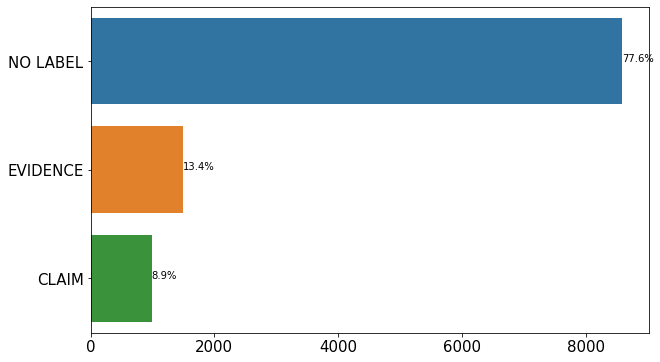

In [12]:
# ploting the cumulative counts of the three labels together with their respective percentages
fig = plt.figure(figsize=(10,6))
ax = sns.countplot(y="label", data=df)
total = len(df)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.05
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
ax.tick_params(labelsize=15)
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

## Data preprocessing

In [13]:
# Cleaning our dataset
import re
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    #Converting some phrases into correct form
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df['sentence'] = df['sentence'].apply(clean_text)
df.sample(10)

,label,sentence,document
1519,EVIDENCE,cases rotterdam project buyzet logistics hub h...,ABC_G1B3_10.1016_j.trpro.2019.06.045.csv
1947,NO LABEL,abstract,DEJ_G2B1_47.csv
976,NO LABEL,categorizing publications based innovation dri...,ABC_G1B2_10.1016_j.technovation.2018.02.015.csv
10750,NO LABEL,captured individuals field measured body tempe...,RST_G7B4_S0306456514000084.csv
5982,NO LABEL,abstract,FOP_G3B3_PMID30893248.csv
429,NO LABEL,india one order improve economy help make indi...,ABC_G1B1_Corpus ID 190457136.csv
1035,EVIDENCE,2 provinces facing ecological overload excludi...,ABC_G1B3_10.1016_j.ecolind.2019.106035.csv
1651,NO LABEL,women value midwifery continuity care model sy...,DEI_G2B1_6.csv
10039,NO LABEL,promote progress toward climateresponsive desi...,NRT_G7B1_S0360132312003022.csv
840,NO LABEL,analysis shows clear differences groups low hi...,ABC_G1B2_10.1016_j.renene.2018.08.069.csv


In [14]:
# Setting constant random seed in order to bring the same numeric values every time
import tensorflow as tf
np.random.seed(10) 
tf.random.set_seed(10)

## Splitting the dataset into Train and Test dataset

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df['sentence'],df['label'], random_state = 10, train_size=0.8,stratify=df['label'])


In [16]:
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, random_state = 10, train_size=0.5,stratify=y_test)


In [17]:
print(X_train.shape, y_train.shape,X_test.shape,y_test.shape, X_val.shape, y_val.shape)

(8851,) (8851,) (1106,) (1106,) (1107,) (1107,)


In [18]:
#Importing the One Hot Encoder
y_enc= OneHotEncoder(sparse=False)

In [19]:
# Encoding Y train dataset
y_train_enc = y_enc.fit_transform(y_train.values.reshape(-1, 1))
y_train_enc

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [20]:
# Then we use the fitted One-hot-Encoder to transform the rest of the data
y_val_enc = y_enc.transform(y_val.values.reshape(-1, 1))

y_test_enc = y_enc.transform(y_test.values.reshape(-1, 1))

In [21]:
print('y_train shape: {}'.format(y_train_enc.shape))
print('y_val shape: {}'.format(y_val_enc.shape))
print('y_test shape: {}'.format(y_test_enc.shape))

y_train shape: (8851, 3)
y_val shape: (1107, 3)
y_test shape: (1106, 3)


In [22]:
# The categories that we obtained by the Encoder
y_enc.categories_

[array(['CLAIM', 'EVIDENCE', 'NO LABEL'], dtype=object)]

In [23]:
# What the aforementioned code did:
temp = pd.DataFrame(y_train_enc)
temp.columns = list(y_enc.categories_[0])
temp.head(10)

,CLAIM,EVIDENCE,NO LABEL
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
5,1.0,0.0,0.0
6,0.0,1.0,0.0
7,0.0,0.0,1.0
8,0.0,0.0,1.0
9,0.0,0.0,1.0


In [24]:
STOPWORDS = set(stopwords.words('english'))

In [25]:
max_words = 500

In [26]:
# This vectorizer will give the number of appearances of each word
counter_vectorizer = CountVectorizer(
    encoding='utf-8',
    strip_accents='unicode',
    lowercase=True,
    stop_words=STOPWORDS,
    ngram_range=(1, 1), # unigrams
    max_features=max_words,
    binary=False # binary output or full counts. 
)
counter_vectorizer

CountVectorizer(max_features=500,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...},
                strip_accents='unicode')

In [27]:
#Fitting the CountVectorizer **ONLY ON THE TRAINING DATASET**
# fitting the CountVectorizer in the training data
X_train_enc = counter_vectorizer.fit_transform(X_train)
# Using the FITTED CountVectorizer we transform the Validation and Test Sets
X_val_enc = counter_vectorizer.transform(X_val)
X_test_enc = counter_vectorizer.transform(X_test)

In [28]:
#Checking the encoding shape of our Sentence datasets
print('X_train encoded shape: {}'.format(X_train_enc.shape))
print('X_val encoded shape: {}'.format(X_val_enc.shape))
print('X_test encoded shape: {}'.format(X_test_enc.shape))

X_train encoded shape: (8851, 500)
X_val encoded shape: (1107, 500)
X_test encoded shape: (1106, 500)


In [29]:
X_train_enc

<8851x500 sparse matrix of type '<class 'numpy.int64'>'
	with 54319 stored elements in Compressed Sparse Row format>

In [30]:
# Checking the first row of X_train after encoding
X_train_enc[0].todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## MLP model

In [31]:
#Setting the hyperparameters
dropout_rate=0.35
nb_classes=3
batch_size=700
nb_epoch=10

In [32]:
print('Building model...', end='\n\n')

# The model that we will create is a sequential model meaning that
# each layer that we add per line will use as input the output of the 
# former layer added to the model

# define an empty sequential structure 
model = Sequential()

# add a dense layer (MLP)
model.add(Dense(512, input_shape=(max_words,)))

# use a relu activation on MLP's outputs
model.add(Activation('relu'))

# use a dropout layer with 
model.add(Dropout(dropout_rate, seed=10))

# add a dense layer (MLP)
model.add(Dense(512))

# use a relu activation on MLP's outputs
model.add(Activation('relu'))

# use a dropout layer 
model.add(Dropout(dropout_rate, seed=10))

# add a dense layer (MLP) 
model.add(Dense(nb_classes))

# use a softmax activation on 2nd MLP's outputs
model.add(Activation('softmax'))

# we have defined the structure of the model

# print model layers' info
print(model.summary())

Building model...

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               256512    
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_5 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3

In [33]:
# We compile the model using categorical crossentropy as a loss function 
# and RMSprop as an optimizer (is more robust thatn Gradient Descent Optimizer)
# As a metric we can use "accuracy"
model.compile(
    loss='categorical_crossentropy',
    optimizer='RMSprop',
    metrics=['accuracy'],
)
# we have compiled a model and it is ready to be trained

In [34]:
# We train (fit our data to) our model
history = model.fit(
    x=X_train_enc.todense(),           # features (as dense inputs)
    y=y_train_enc,           # labels
    batch_size=batch_size,   # define batch size
    epochs=nb_epoch,         # number of epochs
    verbose=2,               # the most extended verbosity level
    validation_data=(       
    X_val_enc.todense(),               # the validation split that we did before
    y_val_enc),callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
)

Epoch 1/10
13/13 - 1s - loss: 0.7505 - accuracy: 0.7321 - val_loss: 0.6541 - val_accuracy: 0.7787
Epoch 2/10
13/13 - 1s - loss: 0.5994 - accuracy: 0.7835 - val_loss: 0.5862 - val_accuracy: 0.7823
Epoch 3/10
13/13 - 1s - loss: 0.5215 - accuracy: 0.8053 - val_loss: 0.5625 - val_accuracy: 0.7859
Epoch 4/10
13/13 - 1s - loss: 0.4752 - accuracy: 0.8173 - val_loss: 0.5632 - val_accuracy: 0.7877
Epoch 5/10
13/13 - 1s - loss: 0.4429 - accuracy: 0.8289 - val_loss: 0.5824 - val_accuracy: 0.7958
Epoch 6/10
13/13 - 1s - loss: 0.4023 - accuracy: 0.8448 - val_loss: 0.5779 - val_accuracy: 0.7760


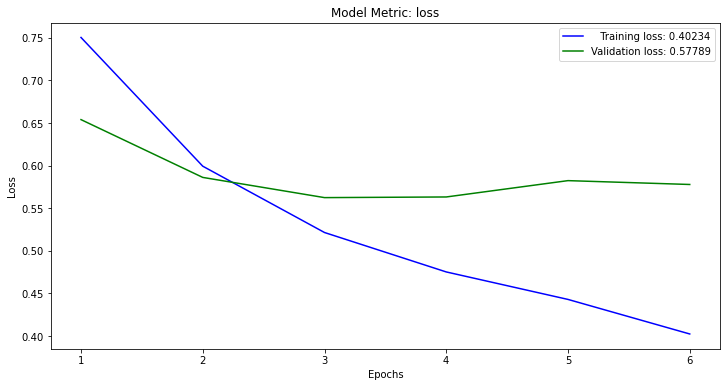

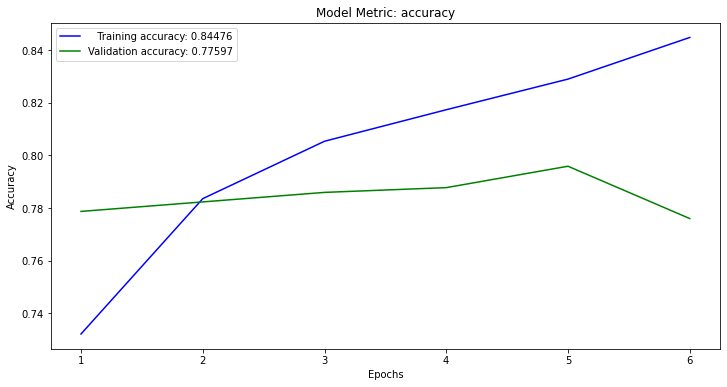

In [35]:
plot_keras_history(history)

In [36]:
mlp_model_final = keras.models.load_model('mlp_model.h1')

In [37]:
# saving the model to json format
open('mlp_model.json', 'w').write(mlp_model_final.to_json())
# saving the weights of the model separately
mlp_model_final.save_weights('weights.h1')

In [38]:
# evaluate and store on score variable on the TEST DATASET
score = mlp_model_final.evaluate(
    X_test_enc.todense(),    # features
    y_test_enc,              # labels
    batch_size=batch_size,   # batch size
    verbose=2                # the most extended verbose
)

2/2 - 0s - loss: 0.5925 - accuracy: 0.7939


In [39]:
print('\nTest categorical_crossentropy: {}'.format(score[0]))
print('\nTest accuracy: {:.3f} %'.format(score[1]*100))


Test categorical_crossentropy: 0.5925481915473938

Test accuracy: 79.385 %


In [40]:
# Use to yield probability distribution over the categories
y_test_pred_probs = mlp_model_final.predict(X_test_enc.todense())
y_test_pred_probs

array([[0.32410192, 0.12071692, 0.5551812 ],
       [0.00925461, 0.00121893, 0.9895265 ],
       [0.06135732, 0.03311232, 0.9055304 ],
       ...,
       [0.01827944, 0.071941  , 0.90977955],
       [0.12690014, 0.04589271, 0.8272072 ],
       [0.01666157, 0.01329098, 0.9700475 ]], dtype=float32)

In [41]:
# Use to yield the predicted classes.
# Depicts which class (number) is 

y_test_preds = np.argmax(mlp_model_final.predict(X_test_enc.todense()), axis=-1)

y_test_preds[:50]

array([2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2], dtype=int64)

In [42]:
# custom prediction function 
def get_one_hot_predictions(pred_probs):
    """
    """
    max_probs = np.max(pred_probs, axis=1)
    
    # reshaping to (len_of_predicts, 1)
    max_probs = max_probs.reshape(max_probs.shape[0], 1)

    return np.equal(pred_probs, max_probs).astype(float)

y_test_pred = get_one_hot_predictions(y_test_pred_probs)
y_test_pred

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [43]:
# More Evaluation Metrics
from sklearn.metrics import confusion_matrix, classification_report
# Now, we will use the fitted One Hot Encoder to Inverse Tranform the ouput
y_test_pred_labels = y_enc.inverse_transform(y_test_pred).flatten()
conf_mat = confusion_matrix(y_true=y_test,
                            y_pred=y_test_pred_labels)
# a bit prettier
pd.DataFrame(conf_mat,
             columns = y_enc.categories_,
             index=y_enc.categories_)


,CLAIM,EVIDENCE,NO LABEL
CLAIM,28,3,68
EVIDENCE,6,26,116
NO LABEL,19,16,824


In [44]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_pred_labels))

              precision    recall  f1-score   support

       CLAIM       0.53      0.28      0.37        99
    EVIDENCE       0.58      0.18      0.27       148
    NO LABEL       0.82      0.96      0.88       859

    accuracy                           0.79      1106
   macro avg       0.64      0.47      0.51      1106
weighted avg       0.76      0.79      0.75      1106



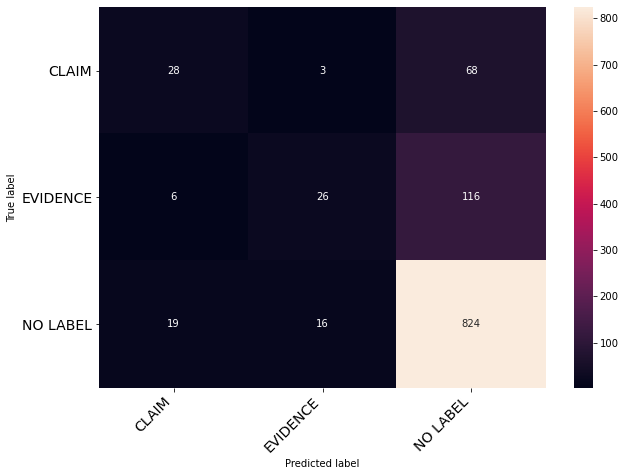

,CLAIM,EVIDENCE,NO LABEL
CLAIM,28,3,68
EVIDENCE,6,26,116
NO LABEL,19,16,824


In [45]:
# Colored confusion matrix
print_confusion_matrix(y_true=y_test,
                           y_pred=y_test_pred_labels,
                           class_names=['CLAIM','EVIDENCE','NO LABEL'])

C:\Users\konst\anaconda3\envs\EnviromentNew\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


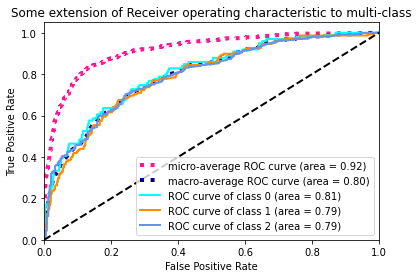

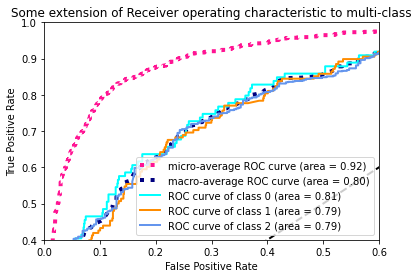

In [46]:
# ROC curve
y_score = model.predict(X_test_enc.todense())

plot_multi_class_roc_auc_curves(nb_classes=3,
                                y_true=y_test_enc,
                                y_pred_score=y_score)

## Final Test Dataset without labels

In [47]:
import pandas as pd
import glob

path = r'C:\Users\konst\Desktop\MSc\3rd Semester\Machine Learning and Content Analytics\dataset\argument_test_set' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df_test = pd.read_csv(filename,  index_col=None,header=None)
    li.append(df_test)

df_test = pd.concat(li, axis=0, ignore_index=True)

In [48]:
df_test

,0
0,Exploration and corrective measures of greenho...
1,Abstract:
2,Greenhouse gas emission is increasing alarming...
3,While researchers are struggling to minimize t...
4,This paper presents mathematical model of para...
...,...
1239,An LCA comparison of beef systems that differ ...
1240,"To enhance future food supply, grassland less ..."
1241,"Furthermore, studies included in our review di..."
1242,We concluded that beef production from dual-pu...


In [49]:
df_test.columns = ['sentence']

In [50]:
# Cleaning the text from unnecessary values and stopwords
#df = swc_doc['df'].reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub(' ', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)    
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df_test['sentence'] = df_test['sentence'].apply(clean_text)
df_test.sample(10)

,sentence
589,across countries little variation health defin...
962,title understanding farmers perceptions adapta...
770,study demonstrated suicide rates adolescents s...
1088,furthermore performance evaluation based speci...
1157,land occupation lowest farms highest stocking ...
392,prevalence sexual violence high among respondents
1211,assessing propagation uncertainties multi obje...
704,keywords five mortality causes death children ...
307,case control study conducted sample 280 marrie...
703,findings showed need emphasis perinatal events...


In [51]:
X_Final_Test_enc=counter_vectorizer.fit_transform(df_test['sentence'])

In [52]:
X_Final_Test_enc[0].todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [53]:
# Use to yield probability distribution over the categories
y_Final_test_pred_probs = mlp_model_final.predict(X_Final_Test_enc.todense())
y_Final_test_pred_probs

array([[0.02165196, 0.08431441, 0.89403355],
       [0.03082867, 0.0349435 , 0.9342278 ],
       [0.03730825, 0.36474526, 0.59794647],
       ...,
       [0.44338164, 0.07159904, 0.48501933],
       [0.00474772, 0.00279905, 0.9924533 ],
       [0.00742947, 0.01325949, 0.97931105]], dtype=float32)

In [54]:
# Use to yield the predicted classes.
# Depicts which class (number) is 

y_Final_test_preds = np.argmax(mlp_model_final.predict(X_Final_Test_enc.todense()), axis=-1)

y_Final_test_preds[:50]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2], dtype=int64)

In [55]:
# custom prediction function 
def get_one_hot_predictions(pred_probs):
    """
    """
    max_probs = np.max(pred_probs, axis=1)
    
    # reshaping to (len_of_predicts, 1)
    max_probs = max_probs.reshape(max_probs.shape[0], 1)

    return np.equal(pred_probs, max_probs).astype(float)

y_Final_test_preds = get_one_hot_predictions(y_Final_test_pred_probs)
y_Final_test_preds

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [56]:
# More Evaluation Metrics
from sklearn.metrics import confusion_matrix, classification_report
# Now, we will use the fitted One Hot Encoder to Inverse Tranform the ouput
y_test_pred_labels = y_enc.inverse_transform(y_Final_test_preds).flatten()

In [57]:
y_test_pred_labels[:50]

array(['NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL',
       'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL',
       'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL',
       'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL',
       'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL',
       'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL',
       'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL',
       'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL',
       'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL',
       'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL'],
      dtype=object)

In [58]:
labels=pd.DataFrame(y_test_pred_labels)

In [59]:
labels

,0
0,NO LABEL
1,NO LABEL
2,NO LABEL
3,NO LABEL
4,NO LABEL
...,...
1239,NO LABEL
1240,NO LABEL
1241,NO LABEL
1242,NO LABEL


In [60]:
Final_Test= pd.concat([df_test['sentence'],labels],axis=1)

In [61]:
Final_Test.columns = ['sentence','label']

In [62]:
Final_Test

,sentence,label
0,exploration corrective measures greenhouse gas...,NO LABEL
1,abstract,NO LABEL
2,greenhouse gas emission increasing alarmingly ...,NO LABEL
3,researchers struggling minimize emission using...,NO LABEL
4,paper presents mathematical model parameters r...,NO LABEL
...,...,...
1239,lca comparison beef systems differ type diet h...,NO LABEL
1240,enhance future food supply grassland less suit...,NO LABEL
1241,furthermore studies included review include re...,NO LABEL
1242,concluded beef production dual purpose cows da...,NO LABEL


In [63]:
Final_Test.to_csv(r'Final_Test_mlp.csv')

## Grid Search

### Importing the necessary libraries

In [106]:
# !pip install pydot
# !pip install graphviz
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
import pydot

In [107]:
#Lists of possible parameters
max_words_list = [200,300,400,500,600,700,800]
batch_size_list = [300,400,500,600,700,800]
dropout_rate_list= [0.25,0.3,0.35,0.4,0.45,0.5,0.55]
nb_epoch_list =  [5,10,30]
#opt_list=['RMSprop', 'Adam']
a_list=[64,128,256,512]
#b_list=[64,128,256,512,1024]

In [108]:
# max sequence length  
max_words = 400
# Number of Epochs that we will train our Feed Forward Network
nb_epoch = 30
# The batch_size of the data that  will be fed to the Model when training
batch_size = 700
# Dropout Rate of the Dropout Layer (how many neurons to shutdown each time)
dropout_rate = 0.5

In [109]:
# custom prediction function 
def get_one_hot_predictions(pred_probs):
  """
  """
  max_probs = np.max(pred_probs, axis=1)
                  
  # reshaping to (len_of_predicts, 1)
  max_probs = max_probs.reshape(max_probs.shape[0], 1)

  return np.equal(pred_probs, max_probs).astype(float)

### Searching for the max Recall (Evidence-Claim) model 

In [110]:
i=0
df_results=pd.DataFrame(columns=['Dense_a', 'Dense_b','Number of epochs', 'Optimizer','Dropout rate', 'Max words', 'Batch size',
                                 'Correctly classified evidences', 'Correctly classified claims','Test categorical_crossentropy',
                                 'Test accuracy'])
for max_words in max_words_list:
  for batch_size in batch_size_list:
    for dropout_rate in dropout_rate_list:
      for nb_epoch in nb_epoch_list:
        #for opt in opt_list:
          for a in a_list:
            #for b in b_list:
              i=i+1
              print('\nIteration: {}'.format(i))
              np.random.seed(10) 
              tf.random.set_seed(10)

              # This vectorizer will give the number of appearances of each word
              counter_vectorizer = CountVectorizer(
                  encoding='utf-8',
                  strip_accents='unicode',
                  lowercase=True,
                  stop_words=STOPWORDS,
                  ngram_range=(1, 2), # unigrams
                  max_features=max_words,
                  binary=False # binary output or full counts. 
              )
              #Fitting the CountVectorizer **ONLY ON THE TRAINING DATASET**
              # fitting the CountVectorizer in the training data
              X_train_enc = counter_vectorizer.fit_transform(X_train)
              # Using the FITTED CountVectorizer we transform the Validation and Test Sets
              X_val_enc = counter_vectorizer.transform(X_val)
              X_test_enc = counter_vectorizer.transform(X_test)
              # Number of Classes for the Y labels (number of lyricists)
              nb_classes = len(y_enc.categories_[0])

              # define an empty sequential structure 
              model = Sequential()
              # add a dense layer (MLP)
              model.add(Dense(a, input_shape=(max_words,)))
              # use a relu activation on MLP's outputs
              model.add(Activation('relu'))
              # use a dropout layer 
              model.add(Dropout(dropout_rate, seed=10))
              # add a dense layer (MLP)
              model.add(Dense(a))
              # use a relu activation on MLP's outputs
              model.add(Activation('relu'))
              # use a dropout layer with with 20% of inputs droped
              model.add(Dropout(dropout_rate, seed=10))
              # add a dense layer (MLP) 
              model.add(Dense(nb_classes))
              # use a softmax activation on 2nd MLP's outputs
              model.add(Activation('softmax'))


              # We compile the model using categorical crossentropy as a loss function

              # RMSprop optimizer
              # As a metric we can use "accuracy"
              model.compile(
                  loss='categorical_crossentropy',
                  optimizer='RMSprop',
                  metrics=['accuracy'],
              )
              # we have compiled a model and it is ready to be trained

              # We train (fit our data to) our model
              history = model.fit(
                  x=X_train_enc.todense(),           # features (as dense inputs)
                  y=y_train_enc,           # labels
                  batch_size=batch_size,   # define batch size
                  epochs=nb_epoch,         # number of epochs
                  verbose=0,               # the most extended verbosity level
                  validation_data=(       
                  X_val_enc.todense(),               # the validation split that we did before
                  y_val_enc),callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
              )

              # evaluate and store on score variable on the TEST DATASET
              score = model.evaluate(
                  X_test_enc.todense(),    # features
                  y_test_enc,              # labels
                  batch_size=batch_size,   # batch size
                  verbose=0                # the most extended verbose
              )

              y_test_pred_probs = model.predict(X_test_enc)
              y_test_pred = get_one_hot_predictions(y_test_pred_probs)

              # Now, we will use the fitted One Hot Encoder to Inverse Tranform the ouput
              y_test_pred_lyricists = y_enc.inverse_transform(y_test_pred).flatten()
              conf_mat = confusion_matrix(y_true=y_test,
                                          y_pred=y_test_pred_lyricists)
              # a bit prettier
              #pd.DataFrame(conf_mat,columns = y_enc.categories_,index=y_enc.categories_)
              if conf_mat[1,1] > 20 and conf_mat[0,0] > 20:
                df_results=df_results.append({'Dense_a' : a , 'Dense_b' : a,'Number of epochs': nb_epoch, 'Optimizer' : 'RMSprop',
                                              'Dropout rate' : dropout_rate,
                                              'Max words': max_words, 'Batch size': batch_size,
                                 'Correctly classified evidences' : conf_mat[1,1], 'Correctly classified claims' : conf_mat[0,0],
                                 'Test categorical_crossentropy':score[0],
                                 'Test accuracy': score[1]*100},ignore_index=True)
                #print('Dense_a: {}'.format(a))
                #print('Dense_b: {}'.format(a))
                #print('Optimizer: {}'.format(opt))   
                #print('\nNumber of epochs: {}'.format(nb_epoch))  
                #print('Dropout rate: {}'.format(dropout_rate))  
                #print('Max words: {}'.format(max_words))
                #print('Batch size: {}'.format(batch_size))
                #print('Correctly classified evidences: {}'.format(conf_mat[1,1]))
                #print('Correctly classified claims: {}'.format(conf_mat[0,0]))
                #print('Test categorical_crossentropy: {}'.format(score[0]))
                #print('\nTest accuracy: {:.3f} %'.format(score[1]*100))


Iteration: 1

Iteration: 2

Iteration: 3

Iteration: 4

Iteration: 5

Iteration: 6

Iteration: 7

Iteration: 8

Iteration: 9

Iteration: 10

Iteration: 11

Iteration: 12

Iteration: 13

Iteration: 14

Iteration: 15

Iteration: 16

Iteration: 17

Iteration: 18

Iteration: 19

Iteration: 20

Iteration: 21

Iteration: 22

Iteration: 23

Iteration: 24

Iteration: 25

Iteration: 26

Iteration: 27

Iteration: 28

Iteration: 29

Iteration: 30

Iteration: 31

Iteration: 32

Iteration: 33

Iteration: 34

Iteration: 35

Iteration: 36

Iteration: 37

Iteration: 38

Iteration: 39

Iteration: 40

Iteration: 41

Iteration: 42

Iteration: 43

Iteration: 44

Iteration: 45

Iteration: 46

Iteration: 47

Iteration: 48

Iteration: 49

Iteration: 50

Iteration: 51

Iteration: 52

Iteration: 53

Iteration: 54

Iteration: 55

Iteration: 56

Iteration: 57

Iteration: 58

Iteration: 59

Iteration: 60

Iteration: 61

Iteration: 62

Iteration: 63

Iteration: 64

Iteration: 65

Iteration: 66

Iteration: 67

Ite


Iteration: 520

Iteration: 521

Iteration: 522

Iteration: 523

Iteration: 524

Iteration: 525

Iteration: 526

Iteration: 527

Iteration: 528

Iteration: 529

Iteration: 530

Iteration: 531

Iteration: 532

Iteration: 533

Iteration: 534

Iteration: 535

Iteration: 536

Iteration: 537

Iteration: 538

Iteration: 539

Iteration: 540

Iteration: 541

Iteration: 542

Iteration: 543

Iteration: 544

Iteration: 545

Iteration: 546

Iteration: 547

Iteration: 548

Iteration: 549

Iteration: 550

Iteration: 551

Iteration: 552

Iteration: 553

Iteration: 554

Iteration: 555

Iteration: 556

Iteration: 557

Iteration: 558

Iteration: 559

Iteration: 560

Iteration: 561

Iteration: 562

Iteration: 563

Iteration: 564

Iteration: 565

Iteration: 566

Iteration: 567

Iteration: 568

Iteration: 569

Iteration: 570

Iteration: 571

Iteration: 572

Iteration: 573

Iteration: 574

Iteration: 575

Iteration: 576

Iteration: 577

Iteration: 578

Iteration: 579

Iteration: 580

Iteration: 581

Iterati


Iteration: 1031

Iteration: 1032

Iteration: 1033

Iteration: 1034

Iteration: 1035

Iteration: 1036

Iteration: 1037

Iteration: 1038

Iteration: 1039

Iteration: 1040

Iteration: 1041

Iteration: 1042

Iteration: 1043

Iteration: 1044

Iteration: 1045

Iteration: 1046

Iteration: 1047

Iteration: 1048

Iteration: 1049

Iteration: 1050

Iteration: 1051

Iteration: 1052

Iteration: 1053

Iteration: 1054

Iteration: 1055

Iteration: 1056

Iteration: 1057

Iteration: 1058

Iteration: 1059

Iteration: 1060

Iteration: 1061

Iteration: 1062

Iteration: 1063

Iteration: 1064

Iteration: 1065

Iteration: 1066

Iteration: 1067

Iteration: 1068

Iteration: 1069

Iteration: 1070

Iteration: 1071

Iteration: 1072

Iteration: 1073

Iteration: 1074

Iteration: 1075

Iteration: 1076

Iteration: 1077

Iteration: 1078

Iteration: 1079

Iteration: 1080

Iteration: 1081

Iteration: 1082

Iteration: 1083

Iteration: 1084

Iteration: 1085

Iteration: 1086

Iteration: 1087

Iteration: 1088

Iteration: 10


Iteration: 1513

Iteration: 1514

Iteration: 1515

Iteration: 1516

Iteration: 1517

Iteration: 1518

Iteration: 1519

Iteration: 1520

Iteration: 1521

Iteration: 1522

Iteration: 1523

Iteration: 1524

Iteration: 1525

Iteration: 1526

Iteration: 1527

Iteration: 1528

Iteration: 1529

Iteration: 1530

Iteration: 1531

Iteration: 1532

Iteration: 1533

Iteration: 1534

Iteration: 1535

Iteration: 1536

Iteration: 1537

Iteration: 1538

Iteration: 1539

Iteration: 1540

Iteration: 1541

Iteration: 1542

Iteration: 1543

Iteration: 1544

Iteration: 1545

Iteration: 1546

Iteration: 1547

Iteration: 1548

Iteration: 1549

Iteration: 1550

Iteration: 1551

Iteration: 1552

Iteration: 1553

Iteration: 1554

Iteration: 1555

Iteration: 1556

Iteration: 1557

Iteration: 1558

Iteration: 1559

Iteration: 1560

Iteration: 1561

Iteration: 1562

Iteration: 1563

Iteration: 1564

Iteration: 1565

Iteration: 1566

Iteration: 1567

Iteration: 1568

Iteration: 1569

Iteration: 1570

Iteration: 15


Iteration: 1995

Iteration: 1996

Iteration: 1997

Iteration: 1998

Iteration: 1999

Iteration: 2000

Iteration: 2001

Iteration: 2002

Iteration: 2003

Iteration: 2004

Iteration: 2005

Iteration: 2006

Iteration: 2007

Iteration: 2008

Iteration: 2009

Iteration: 2010

Iteration: 2011

Iteration: 2012

Iteration: 2013

Iteration: 2014

Iteration: 2015

Iteration: 2016

Iteration: 2017

Iteration: 2018

Iteration: 2019

Iteration: 2020

Iteration: 2021

Iteration: 2022

Iteration: 2023

Iteration: 2024

Iteration: 2025

Iteration: 2026

Iteration: 2027

Iteration: 2028

Iteration: 2029

Iteration: 2030

Iteration: 2031

Iteration: 2032

Iteration: 2033

Iteration: 2034

Iteration: 2035

Iteration: 2036

Iteration: 2037

Iteration: 2038

Iteration: 2039

Iteration: 2040

Iteration: 2041

Iteration: 2042

Iteration: 2043

Iteration: 2044

Iteration: 2045

Iteration: 2046

Iteration: 2047

Iteration: 2048

Iteration: 2049

Iteration: 2050

Iteration: 2051

Iteration: 2052

Iteration: 20


Iteration: 2477

Iteration: 2478

Iteration: 2479

Iteration: 2480

Iteration: 2481

Iteration: 2482

Iteration: 2483

Iteration: 2484

Iteration: 2485

Iteration: 2486

Iteration: 2487

Iteration: 2488

Iteration: 2489

Iteration: 2490

Iteration: 2491

Iteration: 2492

Iteration: 2493

Iteration: 2494

Iteration: 2495

Iteration: 2496

Iteration: 2497

Iteration: 2498

Iteration: 2499

Iteration: 2500

Iteration: 2501

Iteration: 2502

Iteration: 2503

Iteration: 2504

Iteration: 2505

Iteration: 2506

Iteration: 2507

Iteration: 2508

Iteration: 2509

Iteration: 2510

Iteration: 2511

Iteration: 2512

Iteration: 2513

Iteration: 2514

Iteration: 2515

Iteration: 2516

Iteration: 2517

Iteration: 2518

Iteration: 2519

Iteration: 2520

Iteration: 2521

Iteration: 2522

Iteration: 2523

Iteration: 2524

Iteration: 2525

Iteration: 2526

Iteration: 2527

Iteration: 2528

Iteration: 2529

Iteration: 2530

Iteration: 2531

Iteration: 2532

Iteration: 2533

Iteration: 2534

Iteration: 25


Iteration: 2959

Iteration: 2960

Iteration: 2961

Iteration: 2962

Iteration: 2963

Iteration: 2964

Iteration: 2965

Iteration: 2966

Iteration: 2967

Iteration: 2968

Iteration: 2969

Iteration: 2970

Iteration: 2971

Iteration: 2972

Iteration: 2973

Iteration: 2974

Iteration: 2975

Iteration: 2976

Iteration: 2977

Iteration: 2978

Iteration: 2979

Iteration: 2980

Iteration: 2981

Iteration: 2982

Iteration: 2983

Iteration: 2984

Iteration: 2985

Iteration: 2986

Iteration: 2987

Iteration: 2988

Iteration: 2989

Iteration: 2990

Iteration: 2991

Iteration: 2992

Iteration: 2993

Iteration: 2994

Iteration: 2995

Iteration: 2996

Iteration: 2997

Iteration: 2998

Iteration: 2999

Iteration: 3000

Iteration: 3001

Iteration: 3002

Iteration: 3003

Iteration: 3004

Iteration: 3005

Iteration: 3006

Iteration: 3007

Iteration: 3008

Iteration: 3009

Iteration: 3010

Iteration: 3011

Iteration: 3012

Iteration: 3013

Iteration: 3014

Iteration: 3015

Iteration: 3016

Iteration: 30

KeyboardInterrupt: 

In [111]:
df_results

,Dense_a,Dense_b,Number of epochs,Optimizer,Dropout rate,Max words,Batch size,Correctly classified evidences,Correctly classified claims,Test categorical_crossentropy,Test accuracy
0,128,128,5,RMSprop,0.25,200,300,28,22,0.573928,80.741411
1,256,256,5,RMSprop,0.25,200,300,31,25,0.573042,80.108500
2,512,512,5,RMSprop,0.25,200,300,21,24,0.607311,79.837251
3,128,128,10,RMSprop,0.25,200,300,32,22,0.576968,80.470163
4,256,256,10,RMSprop,0.25,200,300,31,25,0.577030,80.379748
...,...,...,...,...,...,...,...,...,...,...,...
1646,64,64,30,RMSprop,0.35,800,300,45,24,0.598794,79.204339
1647,128,128,30,RMSprop,0.35,800,300,33,26,0.578124,78.842676
1648,256,256,30,RMSprop,0.35,800,300,27,23,0.651987,79.656422
1649,512,512,30,RMSprop,0.35,800,300,29,25,0.670775,79.113925


In [112]:
df_results.to_csv(r'df_results3.csv')